# Tutorial 03 - Deep Unfolding with a regression model

The goal of this tutorial is to show how to load data from ROOT TTrees then to use that data to train a deep neural network using Keras/Tensorflow. The goal of the model is to unfold / regress measured quantities (`TPC multiplicity, TOF mult, BEMC mult, vz, ZDC rate`) to determine the MC level true multiplicity (`mult`) 

First we import the packages that we need to read the data and to do some transformations on the arrays.

The `os.environ['KMP_DUPLICATE_LIB_OK']='True'` line is needed on my machine because I have multiple openMP versions installed - causes a warning without this line.

In [1]:
import uproot
import numpy
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Open the data file with the tree of training data

In [2]:
f_train = uproot.open( "/Users/jdb/bnl/work/MLatSTAR/train.root" )

In [3]:
f_train.allkeys()

[b'fPtRes;1',
 b'fCrystalBall;1',
 b'fMultEff;1',
 b'fVzEff;1',
 b'fZDC;1',
 b'mult;2',
 b'mult;1',
 b'hmc_Pt;1',
 b'hmc_Eta;1',
 b'hmc_Mult;1',
 b'hrc_Pt;1',
 b'hrc_Eta;1',
 b'hrc_Mult;1',
 b'hMult;1',
 b'hMultTof;1',
 b'hMultBEMC;1']

Get the TTree from the data file

In [4]:
tree = f_train[b'mult']

In this example we have generated using a ToyMC several event level variables.

In [5]:
tree.show()

reco_mult                  (no streamer)              asdtype('>f4')
tof_mult                   (no streamer)              asdtype('>f4')
bemc_mult                  (no streamer)              asdtype('>f4')
vz                         (no streamer)              asdtype('>f4')
zdcx                       (no streamer)              asdtype('>f4')
mult                       (no streamer)              asdtype('>f4')


In [6]:
arrays = tree.arrays( ["mult", "reco_mult", "tof_mult", "bemc_mult", "vz", "zdcx"] )

Here are the arrays that we got from the tree:

In [7]:
arrays

{b'mult': array([325.,   1., 173., ...,  58.,  73.,  45.], dtype=float32),
 b'reco_mult': array([31.,  1., 44., ..., 17., 30., 21.], dtype=float32),
 b'tof_mult': array([108.,   1.,  39., ...,  16.,  22.,  18.], dtype=float32),
 b'bemc_mult': array([5., 0., 3., ..., 0., 1., 0.], dtype=float32),
 b'vz': array([ 34.962646 ,  26.977768 ,  43.881706 , ..., -62.19352  ,
        -59.450607 ,   2.9815679], dtype=float32),
 b'zdcx': array([44887., 49857., 56948., ..., 62706., 68823., 64753.], dtype=float32)}

Import `matplotlib` for plotting

In [8]:
import matplotlib.pyplot as plt
fs = ( 16, 9 ) # lets make all our figures 16 by 9

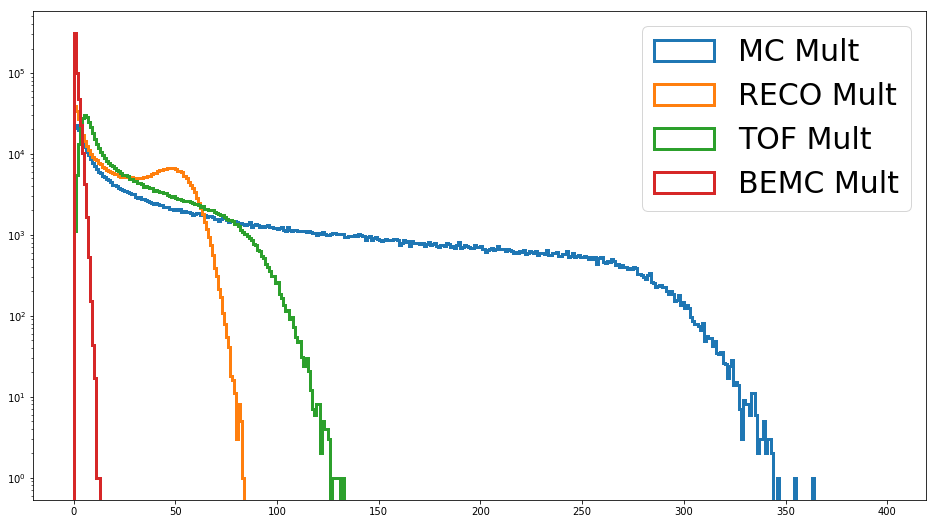

In [9]:
plt.figure(figsize=fs)
plt.hist( arrays[b"mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="MC Mult", linewidth=3 );
plt.hist( arrays[b"reco_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="RECO Mult", linewidth=3 );
plt.hist( arrays[b"tof_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="TOF Mult", linewidth=3 );
plt.hist( arrays[b"bemc_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="BEMC Mult", linewidth=3 );
plt.yscale('log')
plt.gca().legend(prop={'size': 30})

Below is a 2D correlation plot between the reconstructed mult (from TPC) versus the MC level true mult. In this example, I specifically put in a very strong multiplicity dependent efficiency. You can see this cause the correlation change from positive (at low mult) to negative (at high mult).

<img src="reco_vs_mc_mult.png" width="75%"/>

If you want to look at the other variables in the tree then you can do something like this (plot vz):
```
plt.figure(figsize=fs)
plt.hist( arrays[b"vz"].flatten(), bins=range(-200, 205, 5), fill=False, histtype='step', linewidth=3 );
```

## Train a model with Keras
### Start by preparing the data

Make sure to install the needed packages:
```
conda install -c anaconda keras
conda install tensorflow
```

In [10]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor


First, lets define our neural network model. Below we are defining a function which builds the neural network model and returns it.

This example uses a `Sequantial` architecture. A `Sequential` model is a linear stack of node layers. Layers can be added one at a time with various options using the `model.add(...)` function. 

More information about Keras models here: https://keras.io/models/about-keras-models/  
Information about the `Sequential` model is here : https://keras.io/models/sequential/  


In this example we are making a Network with 5 input variables. The first layer has 100 neurons in it and uses a `relu` activation function (See: https://en.wikipedia.org/wiki/Rectifier_(neural_networks) ). The `kernel_initializer` determines how the weights will be initialized. For now we will use a random normal distribution for the initial weights. The second layer has 40 neurons and uses the same activation function. Finally, the output layer has a single neuron (outputs a single value).



In [11]:
def build_model() :
    model = Sequential()
    model.add(Dense(100, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [12]:
# Get the model built in the function above
model = build_model()
# compile the model and set the loss function, optimizer and metrics to check during training.
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


## Get our data into the right shape

In [13]:
n_events = 50000

# Use the below line if you want to train on all of the events
# n_events = len( arrays[b"mult"] ) 

# Make an empty numpy array of the correct shape (since we have 5 input variables)
X_train = numpy.empty( shape=(5, n_events) )

In this next step we copy the input variables (for the number of events we want) into our numpy array. The training/fitting stage wants the arrays setup so that it has a 5-tuple of the input variables for each event. We can easily achieve this by making the arrays and then transposing the numpy 2D array. There may be better ways of doing this so feel free to use other ways of getting you data into the correct shape.

In [14]:
X_train[0] = arrays[b"reco_mult"][:n_events]
X_train[1] = arrays[b"tof_mult"][:n_events]
X_train[2] = arrays[b"bemc_mult"][:n_events]
X_train[3] = arrays[b"vz"][:n_events]
X_train[4] = arrays[b"zdcx"][:n_events]

X_train = numpy.transpose(X_train)
X_train

array([[ 3.10000000e+01,  1.08000000e+02,  5.00000000e+00,
         3.49626465e+01,  4.48870000e+04],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         2.69777679e+01,  4.98570000e+04],
       [ 4.40000000e+01,  3.90000000e+01,  3.00000000e+00,
         4.38817062e+01,  5.69480000e+04],
       ...,
       [ 5.40000000e+01,  6.10000000e+01,  2.00000000e+00,
         2.03196449e+01,  4.97990000e+04],
       [ 9.00000000e+00,  1.00000000e+01,  0.00000000e+00,
         9.71580696e+00,  4.53470000e+04],
       [ 3.00000000e+00,  6.00000000e+00,  0.00000000e+00,
        -5.55137205e+00,  5.09140000e+04]])

Do the same thing for the y varibale - the MC truth multiplicity

In [15]:
Y_train = numpy.transpose( arrays[b"mult"][:n_events] )

## Train/Fit the model

Now we will train the model.

We pass in the X and Y training data.

`epochs` is the number of iterations  
`batch_size` is the number of events to evaluate before updating weights.   
`verbose` controls the output of the progress during training  
`validation_split` controls how much of the dataset is used for training and how much for validation  

In [16]:
history = model.fit(X_train, Y_train, epochs=400, batch_size=5000,  verbose=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/400
40000/40000 [==============================] - 1s 16us/sample - loss: 3902490.1675 - mean_squared_error: 3902489.7500 - mean_absolute_error: 1557.2334 - val_loss: 351906.6719 - val_mean_squared_error: 351906.6562 - val_mean_absolute_error: 582.4112
Epoch 2/400
40000/40000 [==============================] - 0s 2us/sample - loss: 858100.7383 - mean_squared_error: 858100.8125 - mean_absolute_error: 901.8136 - val_loss: 546851.5312 - val_mean_squared_error: 546851.5625 - val_mean_absolute_error: 727.9495
Epoch 3/400
40000/40000 [==============================] - 0s 2us/sample - loss: 164683.8600 - mean_squared_error: 164683.8594 - mean_absolute_error: 328.8280 - val_loss: 127323.2070 - val_mean_squared_error: 127323.2109 - val_mean_absolute_error: 342.1222
Epoch 4/400
40000/40000 [==============================] - 0s 7us/sample - loss: 182386.6885 - mean_squared_error: 182386.6719 

## Results of the Model

We can check the training step by plotting the loss metric for the training and validation datasets as a function of epoch.
NOTE: if you re-run the training without resetting the model, it will start where the last training left off - the weights are not reset when you begin training. 

When we look at the loss for training and validation, we want to be sure they both converge and converge to approximately the same value.

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


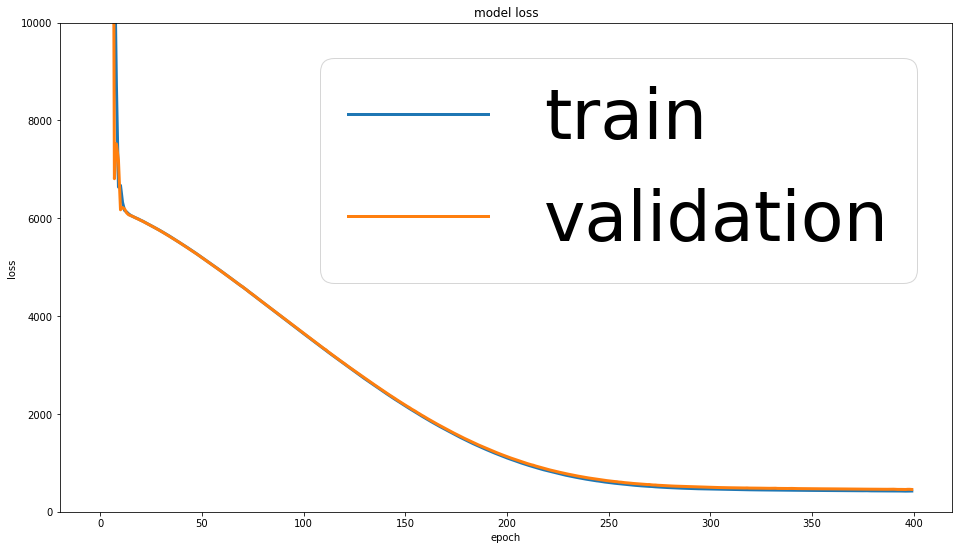

In [17]:
plt.figure(figsize=fs)
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'], linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right', prop={'size': 70})
plt.gca().set_ylim((0, 10000))
plt.show()

In [24]:
f_test = uproot.open( "/Users/jdb/bnl/work/MLatSTAR/test.root" )

In [25]:
tarrays = f_test["mult"].arrays(["mult", "reco_mult", "tof_mult", "bemc_mult", "vz", "zdcx"])

In [26]:
n_events_test = len( tarrays[b"mult"] )
X_test = numpy.empty( shape=(5, n_events_test) )
X_test[0] = tarrays[b"reco_mult"][:n_events_test]
X_test[1] = tarrays[b"tof_mult"][:n_events_test]
X_test[2] = tarrays[b"bemc_mult"][:n_events_test]
X_test[3] = tarrays[b"vz"][:n_events_test]
X_test[4] = tarrays[b"zdcx"][:n_events_test]
X_test = numpy.transpose( X_test )

In [27]:
Y_test = numpy.transpose( tarrays[b"mult"] )

In [36]:
Y_pred = numpy.array(model.predict(X_test))

## Test the model in an independent dataset

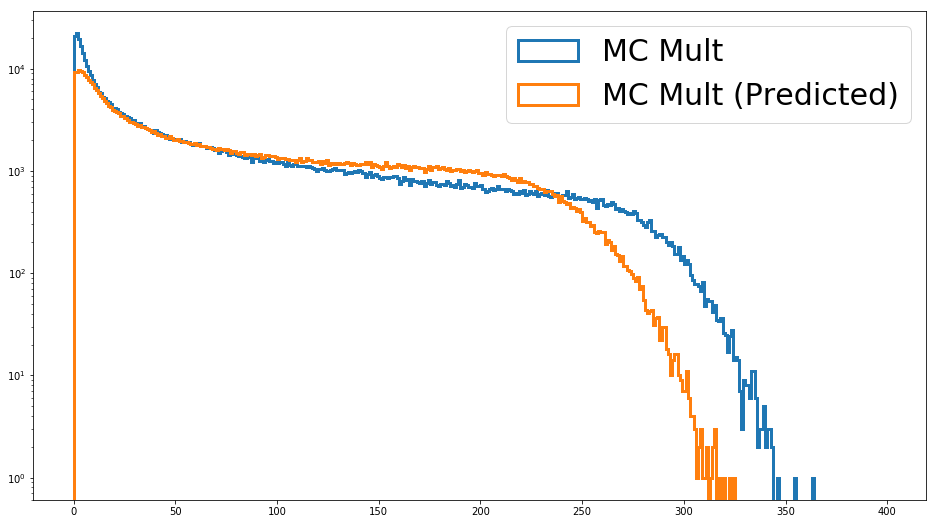

In [37]:

plt.figure(figsize=fs)
plt.hist( Y_test, bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="MC Mult", linewidth=3 )
plt.hist( Y_pred, bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="MC Mult (Predicted)", linewidth=3 )
plt.yscale('log')
plt.gca().legend(prop={'size': 30})

We can see from the direct comparison that the model does a pretty good job of learning the relationhip between 

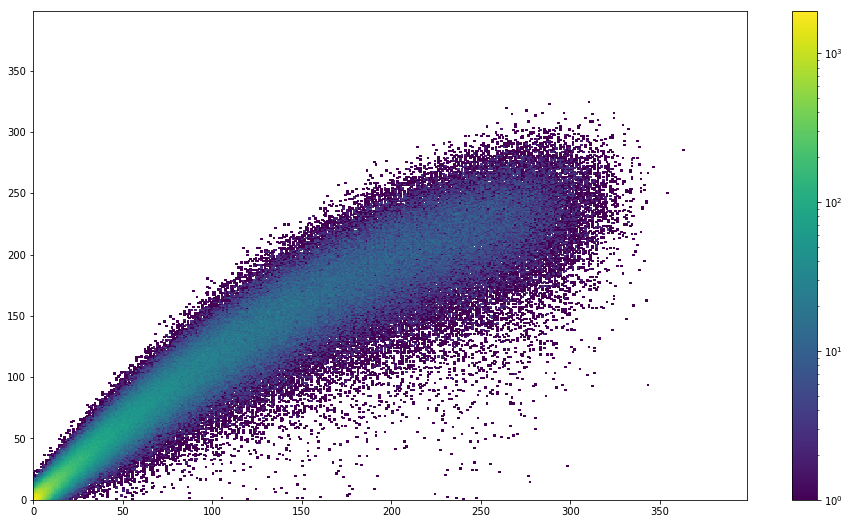

In [48]:
plt.figure(figsize=fs)
from matplotlib.colors import LogNorm
plt.hist2d( Y_test, numpy.transpose(Y_pred)[0], bins=numpy.arange(0, 400, 1), norm=LogNorm() );
plt.colorbar()


In [45]:
numpy.transpose(Y_pred)[0]

array([263.31717 ,  -5.576583, 135.79427 , ...,  46.517838,  77.52492 ,
        54.28795 ], dtype=float32)